In [5]:
%matplotlib inline
# Only if you have a high-resolution "retina" display:
%config InlineBackend.figure_format = 'retina'

import numpy
import matplotlib.pyplot as plt
from astropy import units
from astropy import constants
from astropy.table import QTable  # to use tables with units
from astropy.visualization import quantity_support

quantity_support()
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(10, 8))  # Larger figure sizes
plt.rc('image', origin='lower')  # Make image zero on bottom
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['font.size'] =  16.0

i_units = units.Quantity(1, unit="kW m-2 sr-1 Hz-1")

## Getting data and inverting profiles

Note that in data we have $I_{\nu}^{obs}$.

In [6]:
DATA_FILE = 'SST_sunspot_617_2020_08_07.fits' 
data = QTable.read(DATA_FILE)

#calculating inverted porofiles
data['intensity_inverted'] = data['intensity'][0] - data['intensity']
data['stokes_v_inverted'] = data['stokes_v'][0] - data['stokes_v']

rest_wavelength = 617.30 * units.nm #FeI

## Calculating moments

In [7]:
sp = data['intensity_inverted'] #spectral profile
wv = data['wavelength']
wave0 = rest_wavelength

#calculating moments
moment1 = numpy.trapz(wv[:, numpy.newaxis, numpy.newaxis] * sp, wv, axis=0) / numpy.trapz(sp, wv, axis=0)
moment2 = numpy.trapz((wv[:, numpy.newaxis, numpy.newaxis] - moment1)**2 * sp, wv, axis=0) / numpy.trapz(sp, wv, axis=0)
moment2[moment2 < 0] = 0

## Spectral velocities

In [8]:
#line of sight velocity 
v_los = (constants.c * (wave0 - moment1) / wave0).to('km/s')

width = (numpy.sqrt(moment2) * constants.c / wave0).to('km/s')

In [55]:
def plot_los_velocity(v_los, ax, xmin=None, xmax=None, ymin=None, ymax=None):
    if xmin!=None:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
    
    return ax.imshow(v_los.value, cmap='RdBu')

## Brightness temperatures

Planck function:
\begin{equation} 
   B_\nu(T) = \frac{2h\nu^3}{c^2} 
                  \frac{1}{\mathrm{e}^{h\nu/ kT}-1}
\end{equation}

Inverted Planck function:
\begin{equation}
    \mathrm{e}^{h\nu/ kT}  
    = \frac{2h\nu^3}{c^2} 
    \left(B_\nu(T)\right)^{-1}
    + 1
\end{equation}

\begin{equation}
    h\nu/ kT  
    = \ln{\left[\frac{2h\nu^3}{c^2} 
    \left(B_\nu(T)\right)^{-1}
    + 1\right]}
\end{equation}

\begin{equation}
    T = \frac{h\nu}{k}
    \left(\ln{\left[\frac{2h\nu^3}{c^2} 
    \left(B_\nu(T)\right)^{-1}
    + 1\right]}\right)^{-1}
\end{equation}

Inserting $\left(B_\nu(T_b)\right)^{-1} = I_{\nu}^{obs}$ gives

\begin{equation}
    T_b = \frac{h\nu}{k}
    \left(\ln{\left[\frac{2h\nu^3}{c^2}\left(I_{\nu}^{obs}\right)^{-1}
    + 1\right]}\right)^{-1}
\end{equation}

In [14]:
#adding brightness temperature to dataset
k, h, c = constants.k_B, constants.h, constants.c

nu = data['wavelength'].to(units.Hz, equivalencies=units.spectral())
intensity = data['intensity']

T_b = h*nu/k * numpy.log((2*h*nu**3)/(c**2 * intensity.T*units.sr) + 1)**(-1)
T_b = T_b.decompose()

data['brightness_temperature'] = T_b.T

In [62]:
def plot_brightness_temperature(data, ax, wavelength_index, xmin=None, xmax=None, ymin=None, ymax=None):  
    if xmin!=None:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
    return ax.imshow(data['brightness_temperature'][wavelength_index].value, cmap='inferno')

## Gaussian fit using moments

$$
  f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{\!2}\,\right).
$$

$$
\frac{\partial f}{\partial x} = -f(x, \mu, \sigma) \frac{x-\mu}{\sigma^2}.
$$

In [59]:
def gaussian(x, mu, var): 
    return 1/(numpy.sqrt(var)*numpy.sqrt(2*np.pi))*numpy.exp(-0.5*(x-mu)**2/var)

def dgaussian_dx(x, mu, var, f=gaussian):
    return - f * (x-mu)/var

def scaleBetween(unscaledNum, minAllowed, maxAllowed, minNum, maxNum):
    """
    This is for scaling the gaussian with the right units
    """
    return (maxAllowed - minAllowed) * (unscaledNum - minNum) / (maxNum - minNum) + minAllowed;

In [ ]:
def gaussian_fit() #NOT YET IMPLEMENTED
    """
    Finds gaussian fit at given point x,y for an array of wavelengths
    Returns dict with gaussian fit for the intensity, inverted intensity and their derivatives
    """
    #setting up dict for different fits
    gaussian_fits = {}
    
    return gaussian_fits


# TESTING THE FUNCTIONS

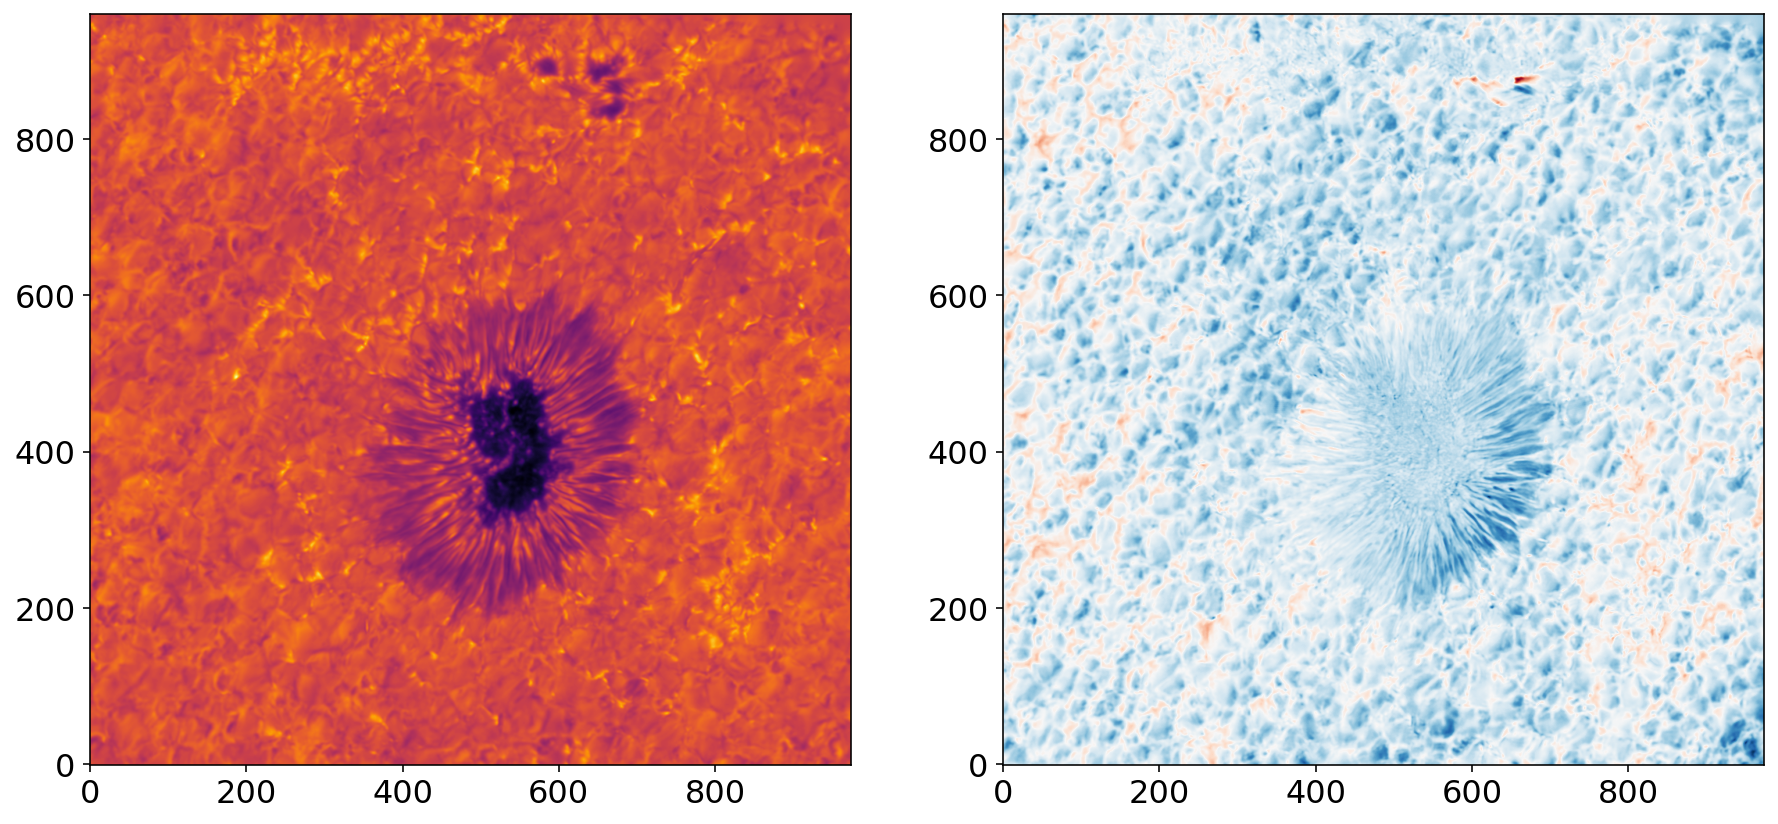

In [63]:
fig, ax = plt.subplots(1,2, figsize=(15,10)) 
im1 = plot_brightness_temperature(data, ax[0], wavelength_index=5, xmin=None, xmax=None, ymin=None, ymax=None)
im2 = plot_los_velocity(v_los, ax[1], xmin=None, xmax=None, ymin=None, ymax=None)

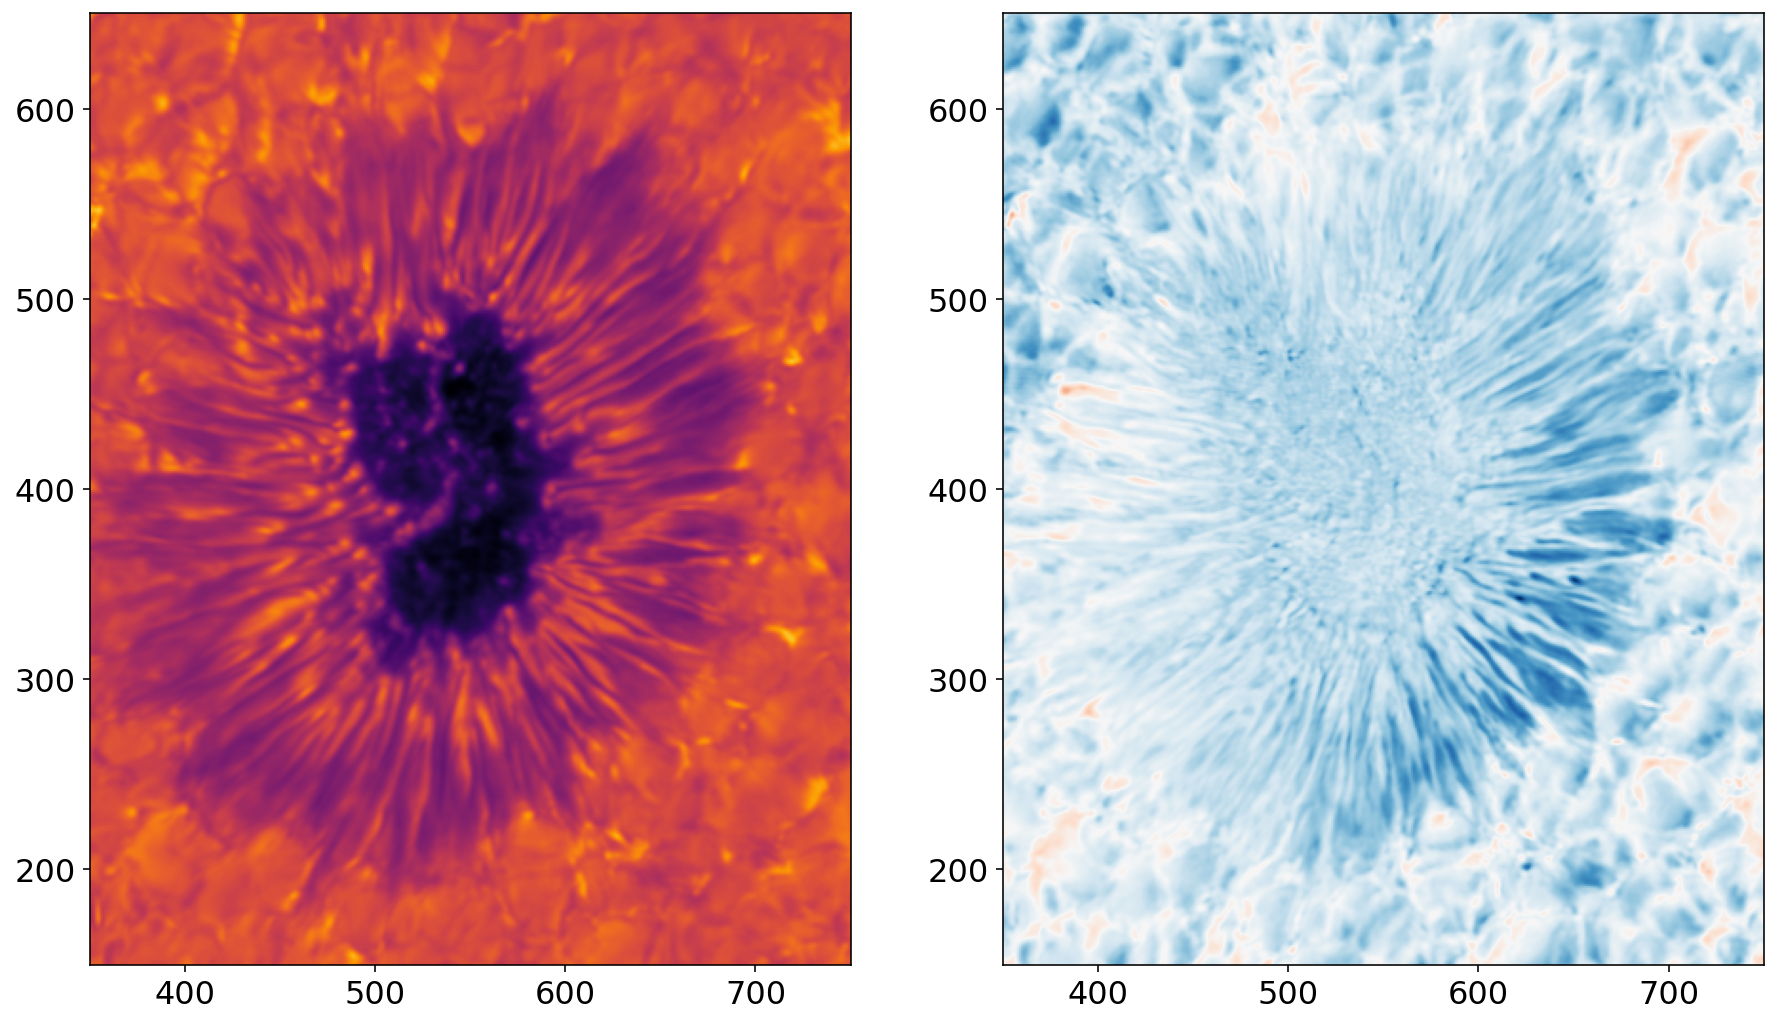

In [64]:
fig, ax = plt.subplots(1,2, figsize=(15,10)) 
im1 = plot_brightness_temperature(data, ax[0], wavelength_index=5, xmin=350, xmax=750, ymin=150, ymax=650)
im2 = plot_los_velocity(v_los, ax[1], xmin=350, xmax=750, ymin=150, ymax=650)